# EMD algorithm - Clustering experiments

## Maria Inês Silva
## 01/02/2019

***

## Data and library imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import extendedMD.emd as emd
import extendedMD.viz as viz

# local code
import sys
import os
sys.path.insert(0, os.path.abspath('../scripts'))
import dtw_clustering as clust

In [3]:
cwd = os.getcwd()
data_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data-uah'))

In [4]:
trip_df = pd.read_pickle(os.path.join(data_folder, 'trip_df.pkl'))
ts = trip_df['ay'].values
events_ts = trip_df['event_type'].values

## Motif detection

In [5]:
r = 0.2
win_size = 15
paa_size = 3
alphabet_size = 5
adaptive_break_points = True

motif_dic_list, ts_1d = emd.find_motifs_from_emd(ts, r, win_size, paa_size, alphabet_size, adaptive_break_points)

Motif candidates of size 1 successfully extracted
Motif candidates of size 2 successfully extracted
Motif candidates of size 3 successfully extracted
Motif candidates of size 4 successfully extracted
Motif candidates of size 5 successfully extracted
Motif candidates of size 6 successfully extracted
Motif candidates of size 7 successfully extracted
Motif candidates of size 8 successfully extracted
Motif candidates of size 9 successfully extracted
Motif candidates of size 10 successfully extracted
Motif candidates of size 11 successfully extracted


In [9]:
motif_df = viz.create_motif_table(motif_dic_list)
motif_df.sort_values('mdl_cost').head(10)

,pattern,pattern_len,n_members,mdl_cost,mean_dist
27,[bdc],1,229,48322.28,0.10
22,[cbd],1,229,48502.38,0.11
25,[bcd],1,205,49278.45,0.10
23,[dbc],1,213,49398.98,0.11
40,[cdb],1,209,49422.79,0.09
37,[dcb],1,207,49764.21,0.10
13,[ccc],1,195,50814.52,0.10
9,[bbe],1,167,51274.92,0.11
24,[add],1,160,51796.93,0.10
32,[dda],1,154,51887.46,0.12


## Clustering of motif's centers 

In [13]:
len(motif_dic_list)

2786

In [12]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)

In [14]:
center_dist_mat = clust.compute_dtw_distance_matrix(center_ts_list, parallel=True)

Distance matrix computed in 36.1 minutes


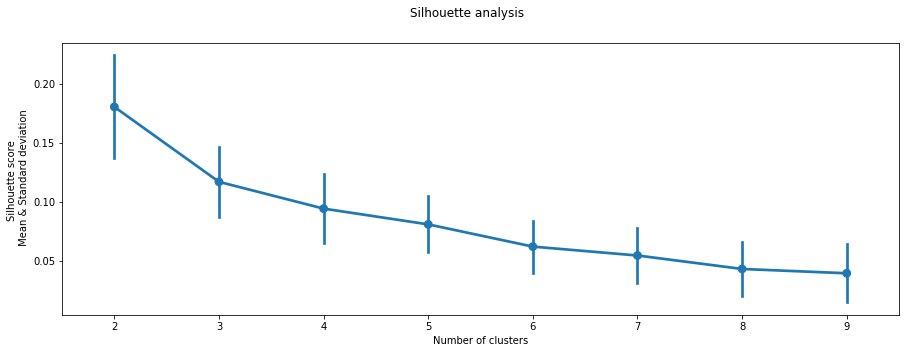

In [18]:
k_list = list(range(2, 10))
n_runs = 40
kmedoids_scores_df = clust.run_kmedoids_evaluation(center_dist_mat, k_list, n_runs)

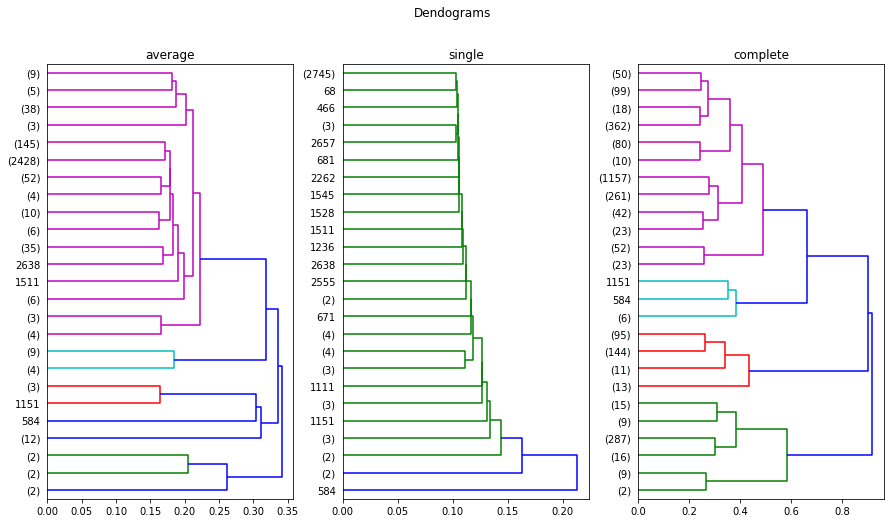

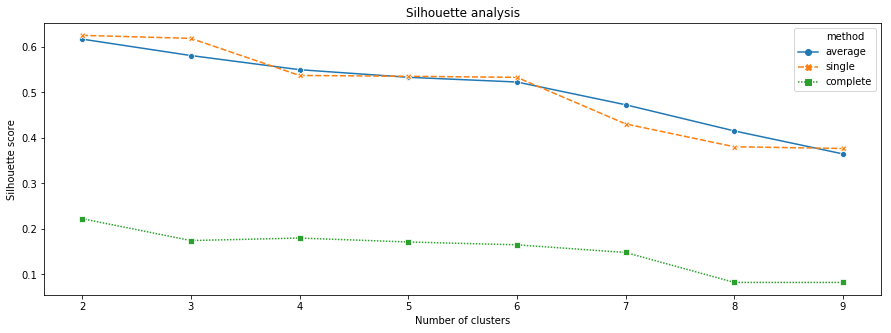

In [20]:
agglomerative_scores_df = clust.run_agglomerative_evaluation(center_dist_mat, k_list)

In [21]:
cluster_labels, score = clust.fit_agglomerative_model(center_dist_mat, k=6, method='complete')

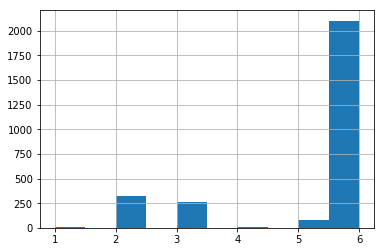

In [26]:
pd.Series(cluster_labels).hist()
plt.show()

## Clusters vizualisation

In [30]:
cluster2 = [dic for i, dic in enumerate(motif_dic_list) if cluster_labels[i] == 2]
len(cluster2)

327

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

cluster2_corpus = [' '.join(dic['pattern']) for dic in cluster2]
vectorizer = CountVectorizer()
count_mat = vectorizer.fit_transform(cluster2_corpus)
print(vectorizer.get_feature_names())
count_mat.toarray()

['abe', 'acd', 'ace', 'add', 'ade', 'aec', 'aed', 'bae', 'bbd', 'bbe', 'bcc', 'bcd', 'bce', 'bdb', 'bdc', 'bdd', 'beb', 'bec', 'cad', 'cae', 'cbc', 'cbd', 'cbe', 'ccb', 'ccc', 'ccd', 'cda', 'cdb', 'cdc', 'cea', 'ceb', 'dac', 'dad', 'dae', 'dbb', 'dbc', 'dbd', 'dca', 'dcb', 'dcc', 'dda', 'ddb', 'eac', 'eba', 'ebb', 'ebc', 'eca', 'ecb', 'eda']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [50]:
pd.DataFrame(count_mat.toarray(), columns=vectorizer.get_feature_names()).sum().reset_index()

abe    11
acd    19
ace    41
add    31
ade     9
aec     1
aed     1
bae     2
bbd    19
bbe    53
bcc     6
bcd    87
bce    13
bdb     6
bdc    66
bdd    20
beb    21
bec     7
cad    14
cae    15
cbc    10
cbd    83
cbe    11
ccb    14
ccc    88
ccd    15
cda    12
cdb    67
cdc    11
cea    16
ceb    11
dac     9
dad    47
dae     2
dbb    35
dbc    61
dbd    28
dca    19
dcb    62
dcc     9
dda    39
ddb    14
eac    11
eba     4
ebb    30
ebc     8
eca    13
ecb    16
eda     2
dtype: int64

### 